# Data exploration and data preprocessing

Here we will see:
- How many images we have
- How many contain hands
- How big is the average video

After this we set some thresholds to decide what we will actually use in the final dataset.
Since the data set is now completely mixed for the preprocessing we also what the seperate them.

In [1]:
import json, os, re, glob
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
%matplotlib inline

In [2]:
json_dir= '../../data/json_3/'

In [18]:
files = os.listdir(json_dir)
frame_amount = []
hand_percentage = []
left_hand= []
right_hand = []
all_labels = []
no_person_per = []
for i, file in enumerate(files):
  # If there is a file that is not a json (.DS_store wtf)
  if 'json' not in file:
    continue
    
  # Load the json file
  with open(join(json_dir,file),'rb') as f:
    json_all = json.load(f)
    json_arr = json_all['data']
  
  if json_all['label'] == '?':
    continue
  
  # Check the number of frames
  num_frames = int(sorted(json_arr.keys())[-1])
  frame_amount.append(num_frames)
 
  # Check how many actually have hands
  c_lhands = 0
  c_rhands = 0
  hands = 0
  no_person = 0
  for k in json_arr.keys():
    try:
      person = json_arr[k][0]
    except:
      no_person += 1
      continue
      
    try:
      lhand = sum(json_arr[k][0]['hand_left_keypoints']) > 0
      rhand = sum(json_arr[k][0]['hand_right_keypoints']) > 0
      if lhand | rhand:
        hands += 1
      
      if lhand:
        c_lhands +=1
      if rhand:
        c_rhands +=1
    except:
      None
  
  hand_percentage.append(hands/num_frames)
  left_hand.append(c_lhands/num_frames)
  right_hand.append(c_rhands/num_frames)
  
  no_person_per.append(1 - no_person/num_frames)
  
  # Check the label
  all_labels.append(json_all['label'])

In [19]:
hist = np.histogram(frame_amount, bins = 52-10, range = (10,52))

[]

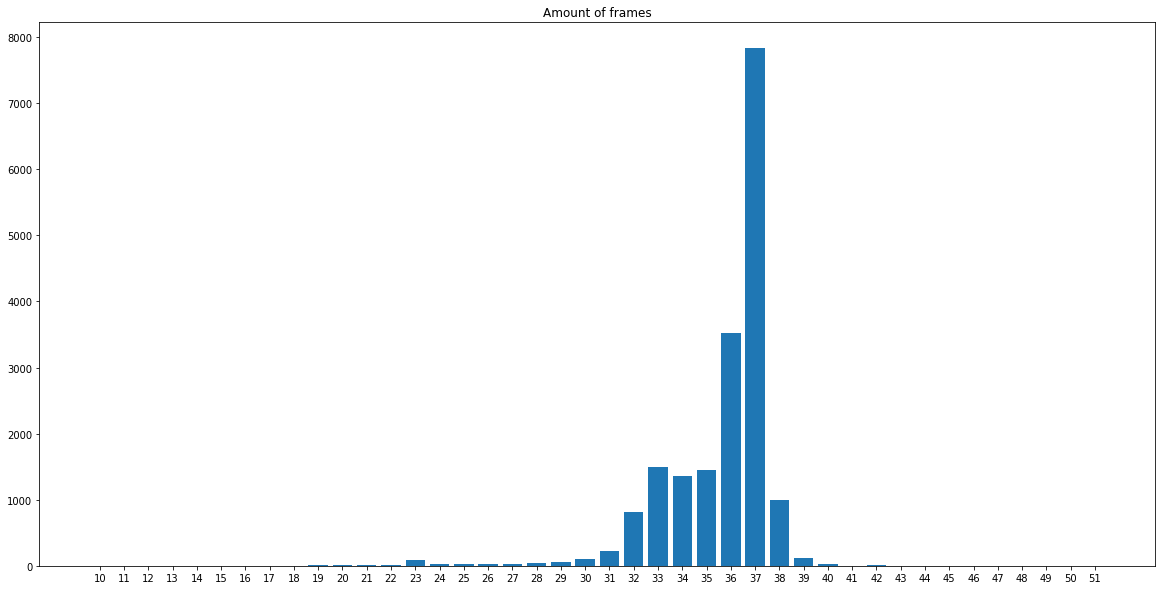

In [20]:
plt.figure(figsize = (20,10))
plt.bar(hist[1][:-1],hist[0])
plt.xticks(hist[1][:-1])
plt.title('Amount of frames')
plt.savefig('ds_num_frames')
plt.plot()

In [21]:
hand_stuff = np.histogram(hand_percentage, bins = 20, range = (0,1) )
lhand_stuff = np.histogram(left_hand, bins = 20, range = (0,1) )
rhand_stuff = np.histogram(right_hand, bins = 20, range = (0,1) )
person_stuff = np.histogram(no_person_per, bins = 20, range = (0,1) )

In [22]:
person_stuff

(array([   70,    15,    24,    23,    40,    39,    39,    55,    62,
           51,    89,    85,   126,   126,   173,   225,   252,   286,
          526, 15990]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))

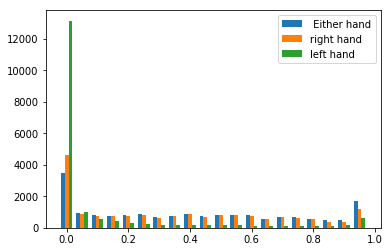

In [23]:
width = (hand_stuff[1][1]-hand_stuff[1][0])/4
plt.bar(hand_stuff[1][:-1]-width, hand_stuff[0], width = width , label =' Either hand')
plt.bar(rhand_stuff[1][:-1], rhand_stuff[0], width = width, label ='right hand')
plt.bar(lhand_stuff[1][:-1]+width, lhand_stuff[0], width = width, label = 'left hand')
plt.legend()

(array([   70,    15,    24,    23,    40,    39,    39,    55,    62,
           51,    89,    85,   126,   126,   173,   225,   252,   286,
          526, 15990]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))

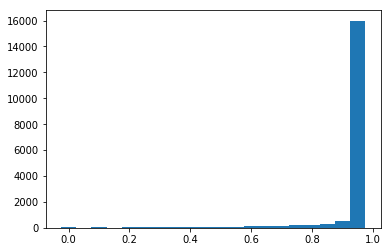

In [24]:
plt.bar(person_stuff[1][:-1], person_stuff[0], width = person_stuff[1][1]-person_stuff[1][0])
person_stuff

In [25]:
mul_5 =  5
sum(hand_stuff[0][:mul_5])/sum(hand_stuff[0])

0.369916921731526

18296


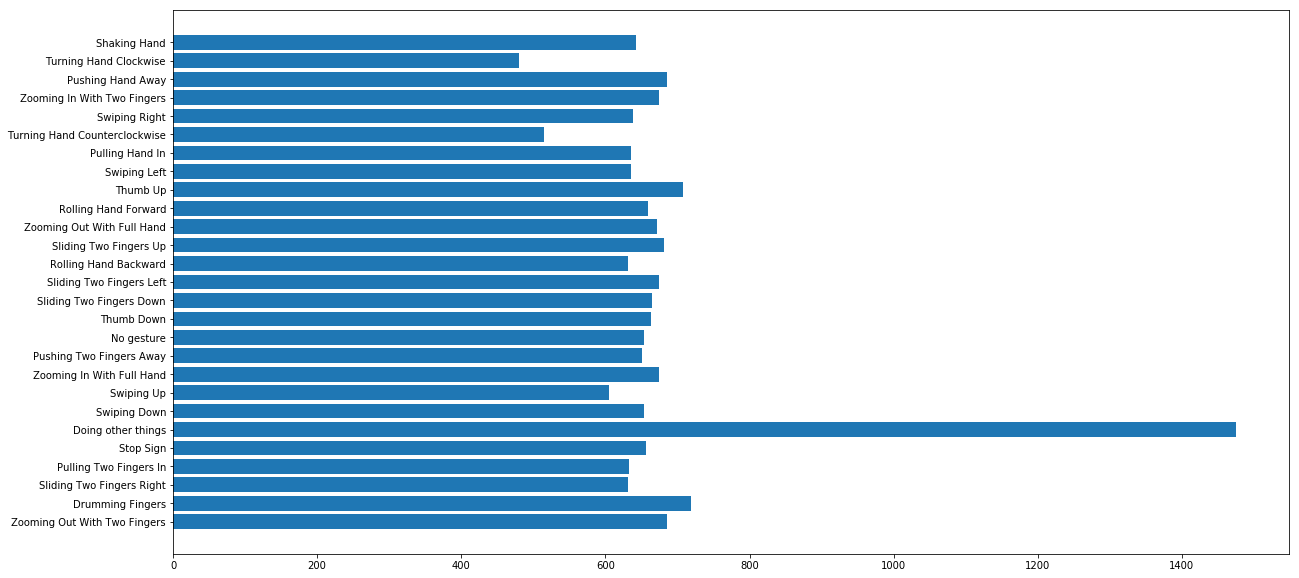

In [26]:
print(len(all_labels))
count = Counter(all_labels)
x, y = count.keys(), count.values()
plt.figure(figsize= (20,10))
plt.barh(list(range(len(x))), y)
_ = plt.yticks(list(range(len(x))),x)

NameError: name 'ead' is not defined